# Identify Human values in Arguments - EDA notebook

SemEval 2023 Task 4; ValueEval: Identification of Human Values behind Arguments.

Author: Mathias Cardarello Fierro

### 1. Data preprocessing
In this section, we tokenize argumentation texts (premises), remove the stop words and, finally, perform lemmatization (stemming does not seem to be necessary at this point).

In [ ]:
## Import basic libraries

import pandas as pd
import os
import glob

import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

import re
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use("fivethirtyeight")
pd.set_option('display.max_colwidth', 80)
import matplotlib.patheffects as path_effects
import nltk
import numpy as np
import seaborn as sns
import gensim

from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler

from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary
from gensim.models.nmf import Nmf
from operator import itemgetter

from scipy.stats import f_oneway, ttest_ind

nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
from collections import Counter
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
## Read processed datasets

df_topic = pd.read_parquet('/content/drive/MyDrive/DSE_fp_files/df_topic.parquet')
df_topic_test = pd.read_parquet('/content/drive/MyDrive/DSE_fp_files/df_topic_test.parquet')

In [ ]:
df_topic.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7389 entries, 0 to 7388
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Argument ID    7389 non-null   object
 1   Premise        7389 non-null   object
 2   Premise_list   7389 non-null   object
 3   Premise_clean  7389 non-null   object
dtypes: object(4)
memory usage: 288.6+ KB


In [ ]:
df_topic_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1855 entries, 0 to 1854
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Argument ID    1855 non-null   object
 1   Premise        1855 non-null   object
 2   Premise_list   1855 non-null   object
 3   Premise_clean  1855 non-null   object
dtypes: object(4)
memory usage: 72.5+ KB


In [ ]:
7389+1855

9244

Reading the files

In [ ]:
## Read the tsv files

path = '/content/drive/MyDrive/DSE_fp_files/'
tsv_files = glob.glob(path + '*.tsv')

# Create an empty dictionary to store the dataframes
df_dic = {}

# Loop through each TSV file, read it into a dataframe, and add it to the dictionary
for file in tsv_files:
    df_name = file.split('/')[-1].split('.')[0]
    df = pd.read_csv(file, delimiter='\t')
    df_dic[df_name] = df


In [ ]:
df_dic['arguments-training'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5393 entries, 0 to 5392
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Argument ID  5393 non-null   object
 1   Conclusion   5393 non-null   object
 2   Stance       5393 non-null   object
 3   Premise      5393 non-null   object
dtypes: object(4)
memory usage: 168.7+ KB


In [ ]:
df_dic['arguments-training'].head(1)

,Argument ID,Conclusion,Stance,Premise
0,A01002,We should ban human cloning,in favor of,we should ban human cloning as it will only cause huge issues when you have ...


In [ ]:
## Merge all arguments with their corresponding labels (TRAINING SET)

arguments = pd.concat([df_dic['arguments-training'], df_dic['arguments-validation'],
                       df_dic['arguments-validation-zhihu']], ignore_index=True)

labels = pd.concat([df_dic['labels-training'], df_dic['labels-validation'],
                       df_dic['labels-validation-zhihu']], ignore_index=True)

df_merged = arguments.merge(labels, on='Argument ID')
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7389 entries, 0 to 7388
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Argument ID                 7389 non-null   object
 1   Conclusion                  7389 non-null   object
 2   Stance                      7389 non-null   object
 3   Premise                     7389 non-null   object
 4   Self-direction: thought     7389 non-null   int64 
 5   Self-direction: action      7389 non-null   int64 
 6   Stimulation                 7389 non-null   int64 
 7   Hedonism                    7389 non-null   int64 
 8   Achievement                 7389 non-null   int64 
 9   Power: dominance            7389 non-null   int64 
 10  Power: resources            7389 non-null   int64 
 11  Face                        7389 non-null   int64 
 12  Security: personal          7389 non-null   int64 
 13  Security: societal          7389 non-null   int6

In [ ]:
## Merge all arguments with their corresponding labels (TEST SET)

arguments = pd.concat([df_dic['arguments-training'], df_dic['arguments-validation'],
                       df_dic['arguments-validation-zhihu']], ignore_index=True)

labels = pd.concat([df_dic['labels-training'], df_dic['labels-validation'],
                       df_dic['labels-validation-zhihu']], ignore_index=True)

df_merged = arguments.merge(labels, on='Argument ID')
df_merged.info()

In [ ]:
df_merged.to_parquet('/content/drive/MyDrive/DSE_fp_files/df_merged.parquet')

In [ ]:
df_merged = pd.read_parquet('/content/drive/MyDrive/DSE_fp_files/df_merged.parquet')

In [ ]:
!git clone https://github.com/touche-webis-de/touche-code.git

Cloning into 'touche-code'...
remote: Enumerating objects: 1857, done.
remote: Counting objects: 100% (145/145), done.
remote: Compressing objects: 100% (92/92), done.
remote: Total 1857 (delta 51), reused 105 (delta 25), pack-reused 1712
Receiving objects: 100% (1857/1857), 10.89 MiB | 15.28 MiB/s, done.
Resolving deltas: 100% (563/563), done.


In [ ]:
cd touche-code/semeval23/human-value-detection/nyt-downloader

/content/touche-code/semeval23/human-value-detection/nyt-downloader


In [ ]:
!pip3 install -r requirements.txt

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.4/83.4 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.4/143.4 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 13.2 MB/s eta 0:00:00
  Created wheel for bs4: filename=bs4-0.0.1-py3-none-any.whl size=1256 sha256=a17cdc410f84cc21bac6ad84f9dbe3ee71f86bf3e8714e1858e5be6e97d4f805
  Stored in directory: /root/.cache/pip/wheels/25/42/45/b773edc52acb16cd2db4cf1a0b47117e2f69bb4eb300ed0e70
Successfully built bs4
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.0.6
    Uninstalling urllib3-2.0.6:
      Successfully uninstalled urllib3-2.0.6


In [ ]:
!python3 -m spacy download en_core_web_sm

2023-10-12 17:42:26.230420: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 17:42:27.359079: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 25.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
## Couldn't load nyt-arguments
!python3 nyt-downloader.py --input-file nyt01-spans.tsv --output-file arguments-test-nyt.tsv

python3: can't open file '/content/nyt-downloader.py': [Errno 2] No such file or directory


In [ ]:
!sha256sum --check arguments-test-nyt.sha256

sha256sum: arguments-test-nyt.tsv: No such file or directory
arguments-test-nyt.tsv: FAILED open or read
sha256sum: WARNING: 1 listed file could not be read


In [ ]:
## Merge all arguments with their corresponding labels (test datasets)

arguments_test = pd.concat([df_dic['arguments-test'], df_dic['arguments-test-nahjalbalagha']]
                       , ignore_index=True)

labels_test = pd.concat([df_dic['labels-test'], df_dic['labels-test-nahjalbalagha']]
                        , ignore_index=True)

df_test = arguments_test.merge(labels_test, on='Argument ID')
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1855 entries, 0 to 1854
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Argument ID                 1855 non-null   object
 1   Conclusion                  1855 non-null   object
 2   Stance                      1855 non-null   object
 3   Premise                     1855 non-null   object
 4   Self-direction: thought     1855 non-null   int64 
 5   Self-direction: action      1855 non-null   int64 
 6   Stimulation                 1855 non-null   int64 
 7   Hedonism                    1855 non-null   int64 
 8   Achievement                 1855 non-null   int64 
 9   Power: dominance            1855 non-null   int64 
 10  Power: resources            1855 non-null   int64 
 11  Face                        1855 non-null   int64 
 12  Security: personal          1855 non-null   int64 
 13  Security: societal          1855 non-null   int6

In [ ]:
df_test.to_parquet('/content/drive/MyDrive/DSE_fp_files/df_test.parquet')

In [ ]:
df_merged.iloc[[15,]].T

,15
Argument ID,A02004
Conclusion,We should ban cosmetic surgery for minors
Stance,in favor of
Premise,children have not grown and truly formed their adult looks. cosmetic surge...
Self-direction: thought,0
Self-direction: action,0
Stimulation,0
Hedonism,0
Achievement,0
Power: dominance,0


In [ ]:
## Keep only Argument ID (for later correlation analysis) and Premise

df_topic = df_merged[['Argument ID', 'Premise']]
df_topic_test = df_test[['Argument ID', 'Premise']]

In [ ]:
## Data preprocessing
# Function to remove unwanted characters, stopwords, and format the text to create fewer nulls word embeddings

def text_preprocessing(text):
    # Based on https://github.com/Idilismiguzel/NLP-with-Python/blob/master/Topic%20Modeling/Disneyland_Reviews_Topic_Modeling_LDA.ipynb

    # Convert words to lower case
    text = text.lower()

    # Format words and remove unwanted characters
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'&amp;', '', text)
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'\'', ' ', text)

    # Tokenize each word
    text = nltk.WordPunctTokenizer().tokenize(text)

    # Remove stopwords (EN)
    all_stopwords = stopwords.words('english')
    text = [token for token in text if not token in all_stopwords]

    # Lemmatize each word
    text = [nltk.stem.WordNetLemmatizer().lemmatize(token) for token in text if len(token)>1]

    # Stemm
    snow = SnowballStemmer(language='english')
    text = [snow.stem(token) for token in text if len(token)>1]

    return text

def to_string(text):
    # Convert list to string
    text = ' '.join(map(str, text))

    return text

In [ ]:
# Create a list of Premise by applying text_preprocessing function
df_topic['Premise_list'] = list(map(text_preprocessing, df_topic.Premise))
df_topic_test['Premise_list'] = list(map(text_preprocessing, df_topic_test.Premise))

# Return to string with to_string function
df_topic['Premise_clean'] = list(map(to_string, df_topic['Premise_list']))
df_topic_test['Premise_clean'] = list(map(to_string, df_topic_test['Premise_list']))

<ipython-input-9-4817fc7b4fc7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_topic['Premise_list'] = list(map(text_preprocessing, df_topic.Premise))
<ipython-input-9-4817fc7b4fc7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_topic_test['Premise_list'] = list(map(text_preprocessing, df_topic_test.Premise))
<ipython-input-9-4817fc7b4fc7>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

In [ ]:
df_topic[['Argument ID', 'Premise', 'Premise_clean']].head(3)

,Argument ID,Premise,Premise_clean
0,A01002,we should ban human cloning as it will only cause huge issues when you have ...,ban human clone caus huge issu bunch human run around act
1,A01005,fast food should be banned because it is really bad for your health and is c...,fast food ban realli bad health cost
2,A01006,sometimes economic sanctions are the only thing that will get the corrupt go...,sometim econom sanction thing get corrupt govern take action


In [ ]:
df_topic_test[['Argument ID', 'Premise', 'Premise_clean']].head(3)

,Argument ID,Premise,Premise_clean
0,A26004,affirmative action helps with employment equity.,affirm action help employ equiti
1,A26010,affirmative action can be considered discriminatory against poor whites,affirm action consid discriminatori poor white
2,A26016,"naturopathy is very dangerous for the most vulnerable people, like children ...",naturopathi danger vulner peopl like child cancer patient peopl use ineffect...


In [ ]:
## Save processed datasets

df_topic.to_parquet('/content/drive/MyDrive/DSE_fp_files/df_topic.parquet')
df_topic_test.to_parquet('/content/drive/MyDrive/DSE_fp_files/df_topic_test.parquet')

In [ ]:
## Read processed datasets

df_topic = pd.read_parquet('/content/drive/MyDrive/DSE_fp_files/df_topic.parquet')
df_topic_test= pd.read_parquet('/content/drive/MyDrive/DSE_fp_files/df_topic_test.parquet')

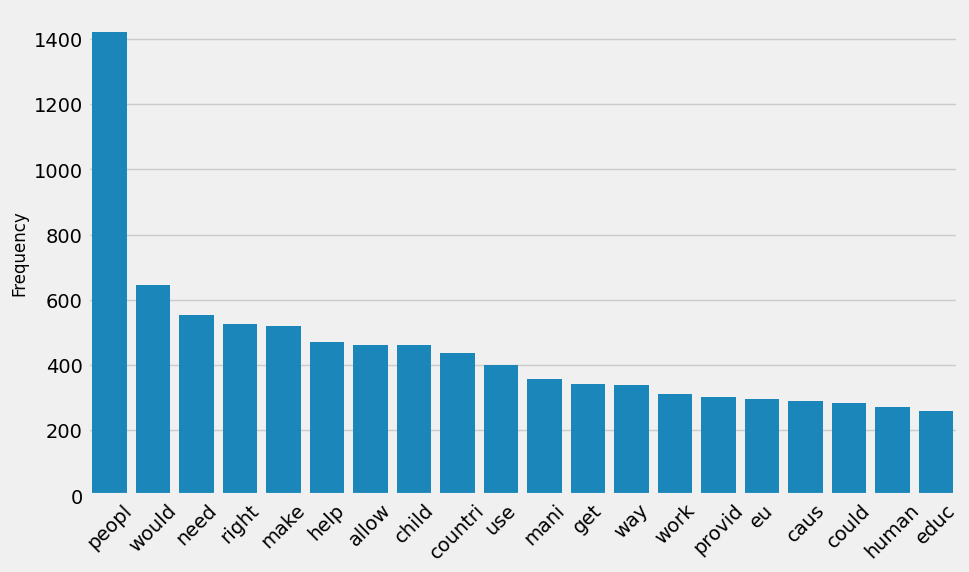

In [ ]:
## Descriptive analysis

## Most frequent words in the dataset
from collections import Counter
# Join all word corpus
premise_words = ','.join(list(df_topic['Premise_clean'].values))

# Count and find the 20 most frequent
Counter = Counter(premise_words.split())
most_frequent = Counter.most_common(20)

# Bar plot of frequent words
fig = plt.figure(1, figsize = (10,6))
_ = pd.DataFrame(most_frequent, columns=("words","count"))
sns.barplot(x = 'words', y = 'count', data = _)
plt.xlabel('', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
#plt.title('Top 20 Words', fontsize=22)
plt.xticks(rotation=45);

In [ ]:
## Get the word count by argument

def word_count(text):
    return len(str(text).split(' '))

df_topic['word_count'] = df_topic['Premise_clean'].apply(word_count)
df_topic['word_count'].mean()

11.647313574231966

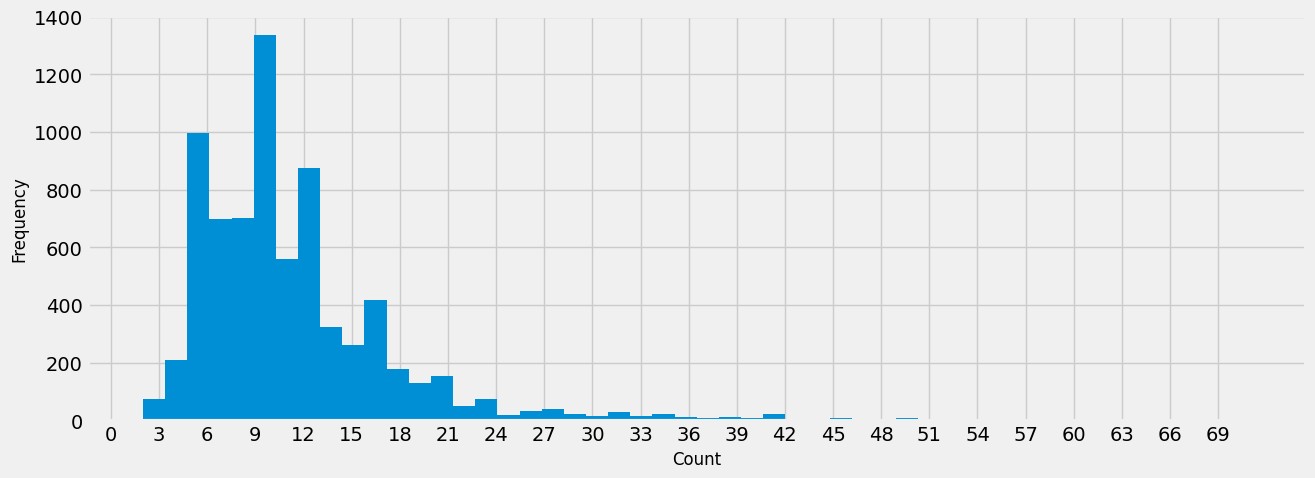

In [ ]:
## Histogram of the word count by argument
fig = plt.figure(figsize=(14,5))

plt.hist(
    df_topic['word_count'],
    bins=50,
)

#plt.title('Distribution - Premise word count', fontsize=16)
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Count', fontsize=12)
plt.xticks(np.arange(0, 70, 3))

plt.show()

In [ ]:
## Descriptive statistics for word count in premises

df_topic['word_count'].describe()

count    7389.000000
mean       11.647314
std         7.102076
min         2.000000
25%         7.000000
50%        10.000000
75%        14.000000
max        71.000000
Name: word_count, dtype: float64

In [ ]:
## Get the number of unique words (after stemming)

p_text = [item for sublist in df_topic['Premise_list'] for item in sublist]
len(set(p_text))

5505

In [ ]:
df_topic.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7389 entries, 0 to 7388
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Argument ID    7389 non-null   object
 1   Premise        7389 non-null   object
 2   Premise_list   7389 non-null   object
 3   Premise_clean  7389 non-null   object
dtypes: object(4)
memory usage: 288.6+ KB


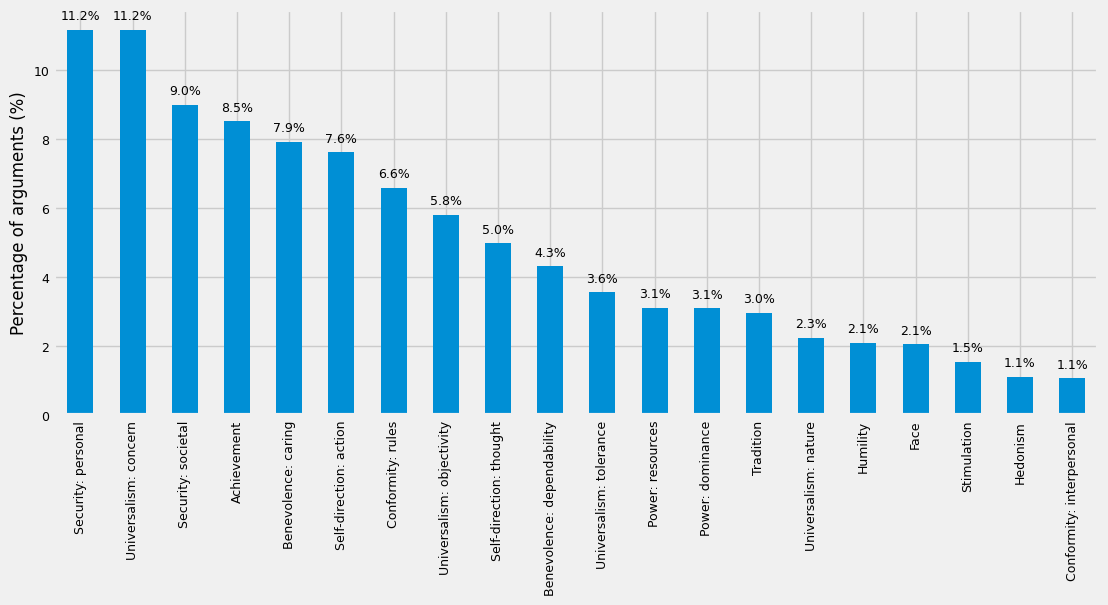

In [ ]:
## Check class balance in training dataset

# Calculate the number of occurrences of each label
label_counts = df_merged.iloc[:, 4:].sum()

# Sort the labels by frequency
label_counts_sorted = label_counts.sort_values(ascending=False)

# Calculate the total number of occurrences to compute percentages
total_counts = label_counts.sum()

# Calculate percentages
label_percentages = (label_counts_sorted / total_counts) * 100

# Plot the class distribution with percentages
plt.figure(figsize=(12, 5))

ax = label_percentages.plot(kind='bar')
#plt.title('Class Distribution of Human Values')
plt.xlabel('', fontsize=12)
plt.ylabel('Percentage of arguments (%)', fontsize=12)

# Adding the value labels as percentages
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=9)

ax.tick_params(axis='x', labelrotation=90, labelsize=9)
ax.tick_params(axis='y', labelsize=9)

plt.show()

In [ ]:
## Token frequency by human value

df_tokens_hv = df_merged.merge(df_topic, on='Argument ID')
df_tokens_hv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7389 entries, 0 to 7388
Data columns (total 27 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Argument ID                 7389 non-null   object
 1   Conclusion                  7389 non-null   object
 2   Stance                      7389 non-null   object
 3   Premise_x                   7389 non-null   object
 4   Self-direction: thought     7389 non-null   int64 
 5   Self-direction: action      7389 non-null   int64 
 6   Stimulation                 7389 non-null   int64 
 7   Hedonism                    7389 non-null   int64 
 8   Achievement                 7389 non-null   int64 
 9   Power: dominance            7389 non-null   int64 
 10  Power: resources            7389 non-null   int64 
 11  Face                        7389 non-null   int64 
 12  Security: personal          7389 non-null   int64 
 13  Security: societal          7389 non-null   int6

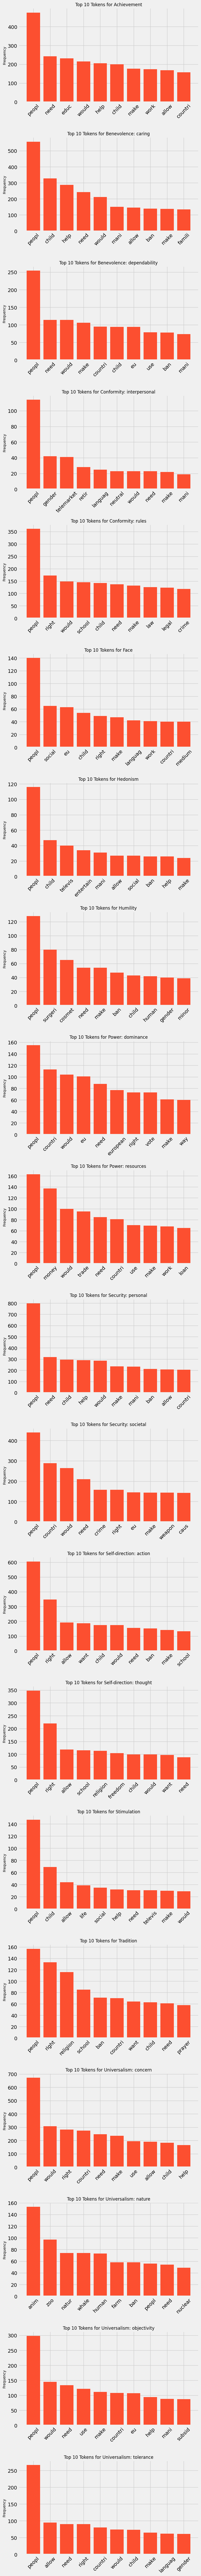

In [ ]:
## Tokens frequency by human values

value_columns = df_tokens_hv.columns[4:24].tolist()
id_vars = ['Argument ID', 'Premise_clean']

melted_df = df_tokens_hv.melt(id_vars=id_vars, value_vars=value_columns, var_name='Human Value', value_name='Value Presence')
melted_df = melted_df[melted_df['Value Presence'] > 0]

# Get unique Human Values
human_values = token_frequencies['Human Value'].unique()

# Initialize an empty DataFrame to store all tokens and their frequencies
all_tokens_df = pd.DataFrame()

# Determine the number of subplots needed (one for each Human Value)
num_subplots = len(human_values)

# Create a figure to hold the subplots
fig, axes = plt.subplots(num_subplots, 1, figsize=(8, 5 * num_subplots))

# Check if there's only one subplot (which would not return an array of axes)
if num_subplots == 1:
    axes = [axes]

for i, value in enumerate(human_values):
    # Filter rows for the current Human Value
    filtered_df = melted_df[melted_df['Human Value'] == value]

    # Tokenize the 'Premise_clean' column
    tokens = filtered_df['Premise_clean'].str.split().explode()

    # Count the frequency of each token
    token_frequency = Counter(tokens)

    # Get the top 10 most common tokens
    top_tokens = token_frequency.most_common(10)

    # Unzip tokens and their frequencies
    tokens, frequencies = zip(*top_tokens)

    # Create a DataFrame from the top tokens and their frequencies
    temp_df = pd.DataFrame({'Token': tokens, 'Frequency': frequencies, 'Human Value': value})

    # Append to the main DataFrame
    all_tokens_df = pd.concat([all_tokens_df, temp_df], ignore_index=True)

    # Plot the frequencies in the ith subplot
    axes[i].bar(tokens, frequencies)
    axes[i].set_title(f'Top 10 Tokens for {value}', fontsize=12)
    axes[i].set_ylabel('Frequency', fontsize=10)
    axes[i].tick_params(axis='x', rotation=45)

    # Plot the frequencies in the ith subplot
    axes[i].bar(tokens, frequencies)
    axes[i].set_title(f'Top 10 Tokens for {value}', fontsize=12)
    axes[i].set_ylabel('Frequency', fontsize=10)
    axes[i].tick_params(axis='x', rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
## DataFrame with a list of frequent tokens by human value

# Assuming melted_df, human_values, and num_subplots are already defined

# Initialize an empty list to store dictionaries of token data
all_tokens_data = []

for value in human_values:
    # Filter rows for the current Human Value
    filtered_df = melted_df[melted_df['Human Value'] == value]

    # Tokenize the 'Premise_clean' column
    tokens = filtered_df['Premise_clean'].str.split().explode()

    # Count the frequency of each token
    token_frequency = Counter(tokens)

    # Get the top 10 most common tokens
    top_tokens = token_frequency.most_common(10)

    # Extract tokens from the list of tuples
    top_tokens_list = [token for token, frequency in top_tokens]

    # Append token data to the list
    all_tokens_data.append({'Human Value': value, 'Top Tokens': top_tokens_list})

# Convert the list of dictionaries to a DataFrame
all_tokens_df = pd.DataFrame(all_tokens_data)

all_tokens_df

,Human Value,Top Tokens
0,Achievement,"[peopl, need, educ, would, help, child, make, work, allow, countri]"
1,Benevolence: caring,"[peopl, child, help, need, would, mani, allow, ban, make, famili]"
2,Benevolence: dependability,"[peopl, need, would, make, countri, child, eu, use, ban, mani]"
3,Conformity: interpersonal,"[peopl, gender, telemarket, retir, languag, neutral, would, need, make, mani]"
4,Conformity: rules,"[peopl, right, would, school, child, need, make, law, legal, crime]"
5,Face,"[peopl, social, eu, child, right, make, languag, work, countri, medium]"
6,Hedonism,"[peopl, child, televis, entertain, mani, allow, social, ban, help, make]"
7,Humility,"[peopl, surgeri, cosmet, need, make, ban, child, human, gender, minor]"
8,Power: dominance,"[peopl, countri, would, eu, need, european, right, vote, make, way]"
9,Power: resources,"[peopl, money, would, trade, need, countri, use, make, work, loan]"


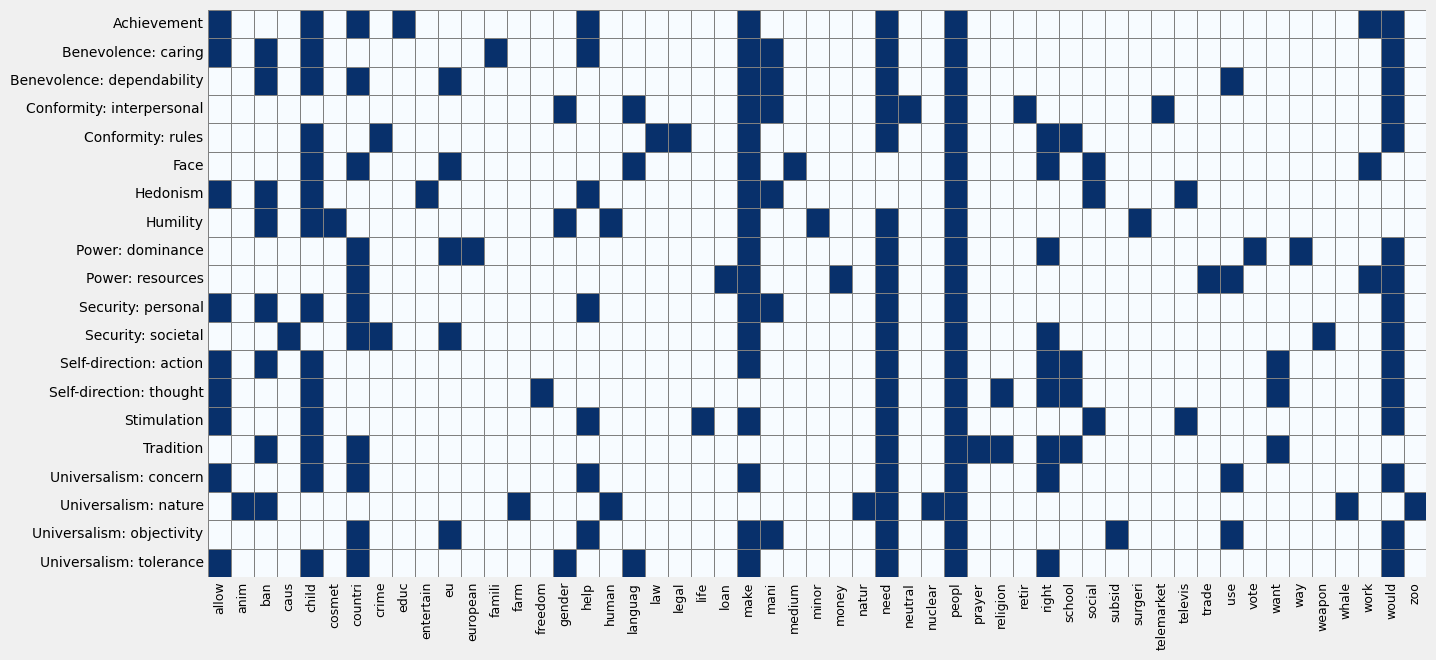

In [ ]:
# Explode the 'Top Tokens' column to create a row for each token
exploded_df = all_tokens_df.explode('Top Tokens')

# Pivot the DataFrame to have tokens as columns and human values as rows
token_presence = pd.pivot_table(exploded_df, index='Human Value', columns='Top Tokens', aggfunc=lambda x: 1, fill_value=0)

# Save dataset
token_presence.to_parquet('/content/drive/MyDrive/DSE_fp_files/token_presence.parquet')

# Create a heatmap with cell borders, decreased font size, and without the color bar legend
plt.figure(figsize=(14, 7))
sns.heatmap(token_presence, cmap='Blues', cbar=False, linewidths=0.5, linecolor='gray', annot=False)
#plt.title('Shared Tokens Across Human Values')
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=90, fontsize=9)
plt.yticks(fontsize=10)
plt.show()

In [ ]:
all_tokens_df[all_tokens_df['Human Value']=='Hedonism']

,Token,Frequency,Human Value
60,peopl,116,Hedonism
61,child,47,Hedonism
62,televis,40,Hedonism
63,entertain,34,Hedonism
64,mani,31,Hedonism
65,allow,27,Hedonism
66,social,27,Hedonism
67,ban,26,Hedonism
68,help,26,Hedonism
69,make,24,Hedonism


In [ ]:
all_tokens_df[all_tokens_df['Human Value']=='Face']

,Token,Frequency,Human Value
50,peopl,140,Face
51,social,65,Face
52,eu,63,Face
53,child,54,Face
54,right,49,Face
55,make,47,Face
56,languag,42,Face
57,work,41,Face
58,countri,40,Face
59,medium,40,Face


In [ ]:
all_tokens_df[all_tokens_df['Human Value']=='Conformity: interpersonal']

,Token,Frequency,Human Value
30,peopl,114,Conformity: interpersonal
31,gender,42,Conformity: interpersonal
32,telemarket,41,Conformity: interpersonal
33,retir,28,Conformity: interpersonal
34,languag,25,Conformity: interpersonal
35,neutral,23,Conformity: interpersonal
36,would,23,Conformity: interpersonal
37,need,23,Conformity: interpersonal
38,make,22,Conformity: interpersonal
39,mani,19,Conformity: interpersonal
